# RAG Pipeline Evaluation

## Retrieval Metrics

### Non LLM Based

In [1]:
from src.config import Settings
from langchain_core.documents import Document
from ast import literal_eval

import pandas as pd

In [5]:
K = 4
df = pd.read_pickle(Settings.TESTS / 'processed-testset.pkl') # This dataset generated by *ragas* testset generator, see `tests`
df.sample(5)

,user_input,reference_contexts,reference,persona_name,query_style,query_length,synthesizer_name,retrieved_contexts,reference_context_ids,retrieved_context_ids
9,ما هو المَنْسَفُ كرمز في الثَّقَافَةِ الأُرْدُ...,[<1-hop>\n\nالخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ ت...,المَنْسَفُ يُعَدُّ تُرَاثاً غَذَائِيّاً أُرْدُ...,NaN,NaN,NaN,multi_hop_specific_query_synthesizer,[طَبَقُ المَنْسَفِ الأُرْدُنِيُّ التَّقْلِيدِي...,[46.0],"[0.0, 46.0, 16.0, 12.0]"
8,What is the recommended quantity of البَسْمَتِ...,[<1-hop>\n\nالأَرْزُ: وَيُفَضَّلُ أَنْ يَكُونَ...,The recommended quantity of البَسْمَتِيِّ rice...,NaN,NaN,NaN,multi_hop_specific_query_synthesizer,[يُقَلَّبُ الأَرْزُ حَتَّى يَتَكَسَّى بِالسَّم...,[6.0],"[29.0, 6.0, 26.0, 28.0]"
4,ما هي أهمية طبق المنسف في الثقافة الأردنية وكي...,[<1-hop>\n\nالخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ ت...,يُعَدُّ المنسف تراثاً غذائياً أردنياً عريقاً، ...,NaN,NaN,NaN,multi_hop_abstract_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,"[46.0, 0.0]","[46.0, 0.0, 36.0, 16.0]"
0,كيف نستخدم قَاعِ الصَّحْنِ الكَبِيرِ في تقديم ...,[خُطْوَةُ التَّقْدِيمِ:\nيُفَرَّشُ خُبْزُ الشَ...,يُفَرَّشُ خُبْزُ الشَّرَاكِ فِي قَاعِ الصَّحْن...,Chef,POOR_GRAMMAR,LONG,single_hop_specific_query_synthesizer,[لَحْمُ الضَّأْنِ بِالعَظْمِ: وَيُفَضَّلُ أَنْ...,[34.0],"[2.0, 38.0, 40.0, 40.0]"
6,كيف يتم غسل اللحم ليكون طري جداً؟,[<1-hop>\n\nخُطْوَةُ تَحْضِيرِ اللَّحْمِ:\nيُغ...,يتم غسل لحم الضأن جيداً بالماء البارد، ثم يوضع...,NaN,NaN,NaN,multi_hop_abstract_query_synthesizer,[خُطْوَةُ تَحْضِيرِ اللَّحْمِ:\nيُغْسَلُ لَحْم...,"[19.0, 41.0]","[19.0, 17.0, 26.0, 21.0]"


#### 1. Precision@K

% of retrieved docs that are relevantRelevant in top K.

Used when you want to avoid showing users irrelevant information (quality over quantity)

In [6]:
def precision_at_k(reference_context_ids: list[int], retrieved_context_ids: list[int], k = 4):
    set_of_reference_context_ids = set(reference_context_ids)
    set_of_retrieved_context_ids = set(retrieved_context_ids[:k])
    return len(set_of_reference_context_ids & set_of_retrieved_context_ids) / K

In [7]:
df['precision@4'] = df.apply(
    lambda raw: precision_at_k(
        reference_context_ids=raw['reference_context_ids'],
        retrieved_context_ids=raw['retrieved_context_ids']
    ), axis=1
)

df['precision@4'].mean()

np.float64(0.2916666666666667)

Precision@4 plummets to 29% when judged by document IDs alone, yet jumps to 70% when evaluated on actual content relevance—revealing that the retriever finds the right information but formal evaluation fails to recognize it.

#### 2. Recall@K
What it measures: Percentage of all relevant documents that were successfully retrieved.

In [8]:
def recall_at_k(reference_context_ids: list[int], retrieved_context_ids: list[int], k = 4):
    set_of_reference_context_ids = set(reference_context_ids)
    set_of_retrieved_context_ids = set(retrieved_context_ids[:k])
    
    return len(set_of_reference_context_ids & set_of_retrieved_context_ids) / len(set_of_reference_context_ids)

In [9]:
df['recall@4'] = df.apply(
    lambda raw: recall_at_k(
        retrieved_context_ids=raw['retrieved_context_ids'],
        reference_context_ids=raw['reference_context_ids'],
    ), axis=1
)

df['recall@4'].mean()

np.float64(0.875)

A recall@4 of 0.875 (87.5%) means that 87.5% of all relevant documents were successfully retrieved within the top 4 results.

#### 3. F1@K
Harmonic mean of Precision@K and Recall@K (balances both).

In [10]:
df['f1@4'] = df.apply(
    lambda raw: 
    2 * (raw['recall@4'] * raw['precision@4']) 
    / 
    (raw['recall@4'] + raw['precision@4']) 
    if (raw['recall@4'] + raw['precision@4']) != 0
    else 0, axis=1
)

df['f1@4'].mean()

np.float64(0.4277777777777778)

#### 4. MRR (Mean Reciprocal Rank)
How quickly you find the FIRST relevant document.

In [11]:
def reciprocal_rank(reference_context_ids: list[int], retrieved_context_ids: list[int]):
    for i, doc_id in enumerate(retrieved_context_ids, start=1):
        if doc_id in reference_context_ids:
            return 1/i
            
    return 0

In [12]:
df['mrr'] = df.apply(
    lambda row: reciprocal_rank(
        retrieved_context_ids=row['retrieved_context_ids'], 
        reference_context_ids=row['reference_context_ids']
    ), 
    axis=1
)

df.mrr.mean()

np.float64(0.6249999999999999)

An MRR of 0.625 means the first relevant document appears at position ~1.6 on average (since 1/1.6 ≈ 0.625). Most queries have their first hit at rank 1 or 2, with occasional misses pushing to rank 3-4.

#### 5. Hit Rate@K
Did we retrieve AT LEAST ONE relevant document?

In [13]:
def hit_rate_at_k(reference_context_ids: list[int], retrieved_context_ids: list[int]):
    for i, doc_id in enumerate(retrieved_context_ids, start=1):
        if doc_id in reference_context_ids:
            return 1
            
    return 0

In [14]:
df['hit_rate@4'] = df.apply(
    lambda row: hit_rate_at_k(
        retrieved_context_ids=row['retrieved_context_ids'], 
        reference_context_ids=row['reference_context_ids']
    ), 
    axis=1
)

df['hit_rate@4'].mean()

np.float64(0.9166666666666666)

A Hit Rate@4 of 0.917 means 91.7% of queries retrieve at least one relevant document within the top 4 results. It's a binary "did we get lucky?" metric—1 if any hit exists, 0 if complete miss.


## RAGAS's Metrics

### 1. Precision@K/Recall@K

In [15]:
from ragas.metrics import IDBasedContextPrecision, IDBasedContextRecall, NonLLMContextPrecisionWithReference 
from ragas.dataset_schema import SingleTurnSample

metrices = [
    ('ragas-precision@4', IDBasedContextPrecision()), 
    ('ragas-recal@4', IDBasedContextRecall())
] # Those are identical to what we have calculated before

for metric_name, metric in metrices:
    df[metric_name] = df.apply(
        lambda row: metric.single_turn_score(
            SingleTurnSample(
                retrieved_context_ids=row['retrieved_context_ids'], 
                reference_context_ids=row['reference_context_ids']
            )
        ), axis=1
    )

df.head()

/tmp/ipykernel_2113827/72196851.py:1: DeprecationWarning: Importing IDBasedContextPrecision from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import IDBasedContextPrecision
  from ragas.metrics import IDBasedContextPrecision, IDBasedContextRecall, NonLLMContextPrecisionWithReference
/tmp/ipykernel_2113827/72196851.py:1: DeprecationWarning: Importing IDBasedContextRecall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import IDBasedContextRecall
  from ragas.metrics import IDBasedContextPrecision, IDBasedContextRecall, NonLLMContextPrecisionWithReference
/tmp/ipykernel_2113827/72196851.py:1: DeprecationWarning: Importing NonLLMContextPrecisionWithReference from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from raga

,user_input,reference_contexts,reference,persona_name,query_style,query_length,synthesizer_name,retrieved_contexts,reference_context_ids,retrieved_context_ids,precision@4,recall@4,f1@4,mrr,hit_rate@4,ragas-precision@4,ragas-recal@4
0,كيف نستخدم قَاعِ الصَّحْنِ الكَبِيرِ في تقديم ...,[خُطْوَةُ التَّقْدِيمِ:\nيُفَرَّشُ خُبْزُ الشَ...,يُفَرَّشُ خُبْزُ الشَّرَاكِ فِي قَاعِ الصَّحْن...,Chef,POOR_GRAMMAR,LONG,single_hop_specific_query_synthesizer,[لَحْمُ الضَّأْنِ بِالعَظْمِ: وَيُفَضَّلُ أَنْ...,[34.0],"[2.0, 38.0, 40.0, 40.0]",0.00,0.0,0.000000,0.000000,0,0.00,0.0
1,What ingredients are typically added along wit...,[يُضَافُ إِلَيْهِ البَصَلُ المُقَطَّعُ وَوَرَق...,"In gourmet cooking, حَبَّاتُ الهَالِ are typic...",Chef de Cuisine,WEB_SEARCH_LIKE,LONG,single_hop_specific_query_synthesizer,[طَرِيقَةُ التَّحْضِيرِ:\n\nخُطْوَةُ نَقْعِ ال...,[20.0],"[17.0, 25.0, 20.0, 10.0]",0.25,1.0,0.400000,0.333333,1,0.25,1.0
2,كيف تُستخدم صلصة الجُميد في تحضير الطعام؟,[يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَ...,يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَل...,Chef de Cuisine,WEB_SEARCH_LIKE,SHORT,single_hop_specific_query_synthesizer,[خُطْوَةُ تَحْضِيرِ صَلْصَةِ الجُمِيدِ:\nفِي ق...,[35.0],"[23.0, 17.0, 35.0, 4.0]",0.25,1.0,0.400000,0.333333,1,0.25,1.0
3,ما هو المَنْسَف وما هي أهميته في الثقافة الأرد...,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,المَنْسَف يُعَدُّ تُرَاثاً غَذَائِيّاً أُرْدُن...,Chef de Cuisine,PERFECT_GRAMMAR,MEDIUM,single_hop_specific_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,[46.0],"[46.0, 0.0, 45.0, 12.0]",0.25,1.0,0.400000,1.000000,1,0.25,1.0
4,ما هي أهمية طبق المنسف في الثقافة الأردنية وكي...,[<1-hop>\n\nالخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ ت...,يُعَدُّ المنسف تراثاً غذائياً أردنياً عريقاً، ...,NaN,NaN,NaN,multi_hop_abstract_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,"[46.0, 0.0]","[46.0, 0.0, 36.0, 16.0]",0.50,1.0,0.666667,1.000000,1,0.50,1.0


### 2. Context Precision

Defines retriver's ability to retrive relevent docs at the top.

In [17]:
from ragas.metrics.collections import ContextPrecision # uses LLM as a judge
from openai import AsyncOpenAI
from ragas.llms import llm_factory
from tqdm import tqdm

client = AsyncOpenAI()
llm = llm_factory("gpt-4o-mini", client=client)

scorer = ContextPrecision(llm=llm)

scores = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    result = await scorer.ascore(
        user_input=row['user_input'],
        reference=row['reference'],
        retrieved_contexts=row['retrieved_contexts']
    )
    scores.append(result.value)
    
df['context_precision'] = scores

df.head(5)

100%|███████████████████████████████████████████████| 12/12 [01:55<00:00,  9.63s/it]


,user_input,reference_contexts,reference,persona_name,query_style,query_length,synthesizer_name,retrieved_contexts,reference_context_ids,retrieved_context_ids,precision@4,recall@4,f1@4,mrr,hit_rate@4,ragas-precision@4,ragas-recal@4,context_precision
0,كيف نستخدم قَاعِ الصَّحْنِ الكَبِيرِ في تقديم ...,[خُطْوَةُ التَّقْدِيمِ:\nيُفَرَّشُ خُبْزُ الشَ...,يُفَرَّشُ خُبْزُ الشَّرَاكِ فِي قَاعِ الصَّحْن...,Chef,POOR_GRAMMAR,LONG,single_hop_specific_query_synthesizer,[لَحْمُ الضَّأْنِ بِالعَظْمِ: وَيُفَضَّلُ أَنْ...,[34.0],"[2.0, 38.0, 40.0, 40.0]",0.00,0.0,0.000000,0.000000,0,0.00,0.0,0.000000
1,What ingredients are typically added along wit...,[يُضَافُ إِلَيْهِ البَصَلُ المُقَطَّعُ وَوَرَق...,"In gourmet cooking, حَبَّاتُ الهَالِ are typic...",Chef de Cuisine,WEB_SEARCH_LIKE,LONG,single_hop_specific_query_synthesizer,[طَرِيقَةُ التَّحْضِيرِ:\n\nخُطْوَةُ نَقْعِ ال...,[20.0],"[17.0, 25.0, 20.0, 10.0]",0.25,1.0,0.400000,0.333333,1,0.25,1.0,0.333333
2,كيف تُستخدم صلصة الجُميد في تحضير الطعام؟,[يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَ...,يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَل...,Chef de Cuisine,WEB_SEARCH_LIKE,SHORT,single_hop_specific_query_synthesizer,[خُطْوَةُ تَحْضِيرِ صَلْصَةِ الجُمِيدِ:\nفِي ق...,[35.0],"[23.0, 17.0, 35.0, 4.0]",0.25,1.0,0.400000,0.333333,1,0.25,1.0,0.416667
3,ما هو المَنْسَف وما هي أهميته في الثقافة الأرد...,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,المَنْسَف يُعَدُّ تُرَاثاً غَذَائِيّاً أُرْدُن...,Chef de Cuisine,PERFECT_GRAMMAR,MEDIUM,single_hop_specific_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,[46.0],"[46.0, 0.0, 45.0, 12.0]",0.25,1.0,0.400000,1.000000,1,0.25,1.0,1.000000
4,ما هي أهمية طبق المنسف في الثقافة الأردنية وكي...,[<1-hop>\n\nالخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ ت...,يُعَدُّ المنسف تراثاً غذائياً أردنياً عريقاً، ...,NaN,NaN,NaN,multi_hop_abstract_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,"[46.0, 0.0]","[46.0, 0.0, 36.0, 16.0]",0.50,1.0,0.666667,1.000000,1,0.50,1.0,1.000000


In [18]:
from ragas.metrics import NonLLMContextPrecisionWithReference

scorer = NonLLMContextPrecisionWithReference()

df['non_llm_context_precision'] = df.apply(
    lambda row:
    scorer.single_turn_score(
        SingleTurnSample(
            retrieved_contexts=row['retrieved_contexts'],
            reference_contexts=row['reference_contexts']
        )
    ), 
    axis=1
)

df.head()

/tmp/ipykernel_2113827/3221307639.py:1: DeprecationWarning: Importing NonLLMContextPrecisionWithReference from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import NonLLMContextPrecisionWithReference
  from ragas.metrics import NonLLMContextPrecisionWithReference


,user_input,reference_contexts,reference,persona_name,query_style,query_length,synthesizer_name,retrieved_contexts,reference_context_ids,retrieved_context_ids,precision@4,recall@4,f1@4,mrr,hit_rate@4,ragas-precision@4,ragas-recal@4,context_precision,non_llm_context_precision
0,كيف نستخدم قَاعِ الصَّحْنِ الكَبِيرِ في تقديم ...,[خُطْوَةُ التَّقْدِيمِ:\nيُفَرَّشُ خُبْزُ الشَ...,يُفَرَّشُ خُبْزُ الشَّرَاكِ فِي قَاعِ الصَّحْن...,Chef,POOR_GRAMMAR,LONG,single_hop_specific_query_synthesizer,[لَحْمُ الضَّأْنِ بِالعَظْمِ: وَيُفَضَّلُ أَنْ...,[34.0],"[2.0, 38.0, 40.0, 40.0]",0.00,0.0,0.000000,0.000000,0,0.00,0.0,0.000000,0.000000
1,What ingredients are typically added along wit...,[يُضَافُ إِلَيْهِ البَصَلُ المُقَطَّعُ وَوَرَق...,"In gourmet cooking, حَبَّاتُ الهَالِ are typic...",Chef de Cuisine,WEB_SEARCH_LIKE,LONG,single_hop_specific_query_synthesizer,[طَرِيقَةُ التَّحْضِيرِ:\n\nخُطْوَةُ نَقْعِ ال...,[20.0],"[17.0, 25.0, 20.0, 10.0]",0.25,1.0,0.400000,0.333333,1,0.25,1.0,0.333333,0.333333
2,كيف تُستخدم صلصة الجُميد في تحضير الطعام؟,[يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَ...,يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَل...,Chef de Cuisine,WEB_SEARCH_LIKE,SHORT,single_hop_specific_query_synthesizer,[خُطْوَةُ تَحْضِيرِ صَلْصَةِ الجُمِيدِ:\nفِي ق...,[35.0],"[23.0, 17.0, 35.0, 4.0]",0.25,1.0,0.400000,0.333333,1,0.25,1.0,0.416667,0.333333
3,ما هو المَنْسَف وما هي أهميته في الثقافة الأرد...,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,المَنْسَف يُعَدُّ تُرَاثاً غَذَائِيّاً أُرْدُن...,Chef de Cuisine,PERFECT_GRAMMAR,MEDIUM,single_hop_specific_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,[46.0],"[46.0, 0.0, 45.0, 12.0]",0.25,1.0,0.400000,1.000000,1,0.25,1.0,1.000000,1.000000
4,ما هي أهمية طبق المنسف في الثقافة الأردنية وكي...,[<1-hop>\n\nالخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ ت...,يُعَدُّ المنسف تراثاً غذائياً أردنياً عريقاً، ...,NaN,NaN,NaN,multi_hop_abstract_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,"[46.0, 0.0]","[46.0, 0.0, 36.0, 16.0]",0.50,1.0,0.666667,1.000000,1,0.50,1.0,1.000000,1.000000


### 3. Context Recall

Did we retrieve all the information needed to answer? (completeness)

In [19]:
from ragas.metrics.collections import ContextRecall

scorer = ContextRecall(llm=llm)

scores = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    result = await scorer.ascore(
        user_input=row['user_input'],
        reference=row['reference'],
        retrieved_contexts=row['retrieved_contexts']
    )
    scores.append(result.value)
    
df['context_recall'] = scores

df.head(5)

100%|███████████████████████████████████████████████| 12/12 [01:01<00:00,  5.12s/it]


,user_input,reference_contexts,reference,persona_name,query_style,query_length,synthesizer_name,retrieved_contexts,reference_context_ids,retrieved_context_ids,precision@4,recall@4,f1@4,mrr,hit_rate@4,ragas-precision@4,ragas-recal@4,context_precision,non_llm_context_precision,context_recall
0,كيف نستخدم قَاعِ الصَّحْنِ الكَبِيرِ في تقديم ...,[خُطْوَةُ التَّقْدِيمِ:\nيُفَرَّشُ خُبْزُ الشَ...,يُفَرَّشُ خُبْزُ الشَّرَاكِ فِي قَاعِ الصَّحْن...,Chef,POOR_GRAMMAR,LONG,single_hop_specific_query_synthesizer,[لَحْمُ الضَّأْنِ بِالعَظْمِ: وَيُفَضَّلُ أَنْ...,[34.0],"[2.0, 38.0, 40.0, 40.0]",0.00,0.0,0.000000,0.000000,0,0.00,0.0,0.000000,0.000000,0.0
1,What ingredients are typically added along wit...,[يُضَافُ إِلَيْهِ البَصَلُ المُقَطَّعُ وَوَرَق...,"In gourmet cooking, حَبَّاتُ الهَالِ are typic...",Chef de Cuisine,WEB_SEARCH_LIKE,LONG,single_hop_specific_query_synthesizer,[طَرِيقَةُ التَّحْضِيرِ:\n\nخُطْوَةُ نَقْعِ ال...,[20.0],"[17.0, 25.0, 20.0, 10.0]",0.25,1.0,0.400000,0.333333,1,0.25,1.0,0.333333,0.333333,1.0
2,كيف تُستخدم صلصة الجُميد في تحضير الطعام؟,[يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَ...,يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَل...,Chef de Cuisine,WEB_SEARCH_LIKE,SHORT,single_hop_specific_query_synthesizer,[خُطْوَةُ تَحْضِيرِ صَلْصَةِ الجُمِيدِ:\nفِي ق...,[35.0],"[23.0, 17.0, 35.0, 4.0]",0.25,1.0,0.400000,0.333333,1,0.25,1.0,0.416667,0.333333,1.0
3,ما هو المَنْسَف وما هي أهميته في الثقافة الأرد...,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,المَنْسَف يُعَدُّ تُرَاثاً غَذَائِيّاً أُرْدُن...,Chef de Cuisine,PERFECT_GRAMMAR,MEDIUM,single_hop_specific_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,[46.0],"[46.0, 0.0, 45.0, 12.0]",0.25,1.0,0.400000,1.000000,1,0.25,1.0,1.000000,1.000000,1.0
4,ما هي أهمية طبق المنسف في الثقافة الأردنية وكي...,[<1-hop>\n\nالخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ ت...,يُعَدُّ المنسف تراثاً غذائياً أردنياً عريقاً، ...,NaN,NaN,NaN,multi_hop_abstract_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,"[46.0, 0.0]","[46.0, 0.0, 36.0, 16.0]",0.50,1.0,0.666667,1.000000,1,0.50,1.0,1.000000,1.000000,1.0


In [20]:
from ragas.metrics import NonLLMContextRecall

scorer = NonLLMContextRecall()

df['non_llm_context_recall'] = df.apply(
    lambda row:
    scorer.single_turn_score(
        SingleTurnSample(
            retrieved_contexts=row['retrieved_contexts'],
            reference_contexts=row['reference_contexts']
        )
    ), 
    axis=1
)

df.head()

/tmp/ipykernel_2113827/1067614103.py:1: DeprecationWarning: Importing NonLLMContextRecall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import NonLLMContextRecall
  from ragas.metrics import NonLLMContextRecall


,user_input,reference_contexts,reference,persona_name,query_style,query_length,synthesizer_name,retrieved_contexts,reference_context_ids,retrieved_context_ids,...,recall@4,f1@4,mrr,hit_rate@4,ragas-precision@4,ragas-recal@4,context_precision,non_llm_context_precision,context_recall,non_llm_context_recall
0,كيف نستخدم قَاعِ الصَّحْنِ الكَبِيرِ في تقديم ...,[خُطْوَةُ التَّقْدِيمِ:\nيُفَرَّشُ خُبْزُ الشَ...,يُفَرَّشُ خُبْزُ الشَّرَاكِ فِي قَاعِ الصَّحْن...,Chef,POOR_GRAMMAR,LONG,single_hop_specific_query_synthesizer,[لَحْمُ الضَّأْنِ بِالعَظْمِ: وَيُفَضَّلُ أَنْ...,[34.0],"[2.0, 38.0, 40.0, 40.0]",...,0.0,0.000000,0.000000,0,0.00,0.0,0.000000,0.000000,0.0,0.0
1,What ingredients are typically added along wit...,[يُضَافُ إِلَيْهِ البَصَلُ المُقَطَّعُ وَوَرَق...,"In gourmet cooking, حَبَّاتُ الهَالِ are typic...",Chef de Cuisine,WEB_SEARCH_LIKE,LONG,single_hop_specific_query_synthesizer,[طَرِيقَةُ التَّحْضِيرِ:\n\nخُطْوَةُ نَقْعِ ال...,[20.0],"[17.0, 25.0, 20.0, 10.0]",...,1.0,0.400000,0.333333,1,0.25,1.0,0.333333,0.333333,1.0,1.0
2,كيف تُستخدم صلصة الجُميد في تحضير الطعام؟,[يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَ...,يُسْكَبُ القَلِيلُ مِنْ صَلْصَةِ الجُمِيدِ عَل...,Chef de Cuisine,WEB_SEARCH_LIKE,SHORT,single_hop_specific_query_synthesizer,[خُطْوَةُ تَحْضِيرِ صَلْصَةِ الجُمِيدِ:\nفِي ق...,[35.0],"[23.0, 17.0, 35.0, 4.0]",...,1.0,0.400000,0.333333,1,0.25,1.0,0.416667,0.333333,1.0,1.0
3,ما هو المَنْسَف وما هي أهميته في الثقافة الأرد...,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,المَنْسَف يُعَدُّ تُرَاثاً غَذَائِيّاً أُرْدُن...,Chef de Cuisine,PERFECT_GRAMMAR,MEDIUM,single_hop_specific_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,[46.0],"[46.0, 0.0, 45.0, 12.0]",...,1.0,0.400000,1.000000,1,0.25,1.0,1.000000,1.000000,1.0,1.0
4,ما هي أهمية طبق المنسف في الثقافة الأردنية وكي...,[<1-hop>\n\nالخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ ت...,يُعَدُّ المنسف تراثاً غذائياً أردنياً عريقاً، ...,NaN,NaN,NaN,multi_hop_abstract_query_synthesizer,[الخَاتِمَةُ:\nيُعَدُّ المَنْسَفُ تُرَاثاً غَذ...,"[46.0, 0.0]","[46.0, 0.0, 36.0, 16.0]",...,1.0,0.666667,1.000000,1,0.50,1.0,1.000000,1.000000,1.0,1.0


In [23]:
df[[
    'ragas-precision@4',	
    'ragas-recal@4',
    'f1@4',
    'context_precision',	
    'context_recall',
    'non_llm_context_precision',	
    'non_llm_context_recall',
    'hit_rate@4',
    'mrr'
]].describe().T

,count,mean,std,min,25%,50%,75%,max
ragas-precision@4,12.0,0.291667,0.144338,0.0,0.250000,0.250000,0.312500,0.500000
ragas-recal@4,12.0,0.875000,0.310791,0.0,1.000000,1.000000,1.000000,1.000000
f1@4,12.0,0.427778,0.183035,0.0,0.400000,0.400000,0.466667,0.666667
context_precision,12.0,0.706019,0.332798,0.0,0.479167,0.791667,1.000000,1.000000
context_recall,12.0,0.791667,0.334279,0.0,0.500000,1.000000,1.000000,1.000000
non_llm_context_precision,12.0,0.604167,0.339200,0.0,0.333333,0.500000,1.000000,1.000000
non_llm_context_recall,12.0,0.875000,0.310791,0.0,1.000000,1.000000,1.000000,1.000000
hit_rate@4,12.0,0.916667,0.288675,0.0,1.000000,1.000000,1.000000,1.000000
mrr,12.0,0.625000,0.356222,0.0,0.333333,0.500000,1.000000,1.000000


**Context Precision (0.706):** 70.6% semantic relevance means 3 of every 10 retrieved chunks are noise—far better than ID-based precision (~0.29), proving semantic filtering catches meaning mismatches that exact-ID matching misses. This gap exposes ID-based metrics as overly optimistic; surface word overlap doesn't guarantee usefulness.


**Context Recall (0.792):** Captures 79.2% of semantic meaning vs. 87.5% ID recall—tighter but truer. The 8-point drop suggests ground-truth chunks often share keywords without genuine semantic alignment; semantic recall filters these "false friends" but risks missing tangentially relevant context.


**Non-LLM Context Precision (0.604):** Basic semantic scoring marks 60.4% as relevant—10% inflated versus LLM-judged precision. Simple embeddings confuse superficial similarity with actual relevance; LLM validation catches subtle distinctions, justifying its computational cost.


**Non-LLM Context Recall (0.875):** Matches ID-based recall exactly, revealing that basic semantic overlap finds the same chunks as exact matching—just with noisier relevance scoring. The LLM's value isn't finding more; it's judging better.

/tmp/ipykernel_2113827/1514313254.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


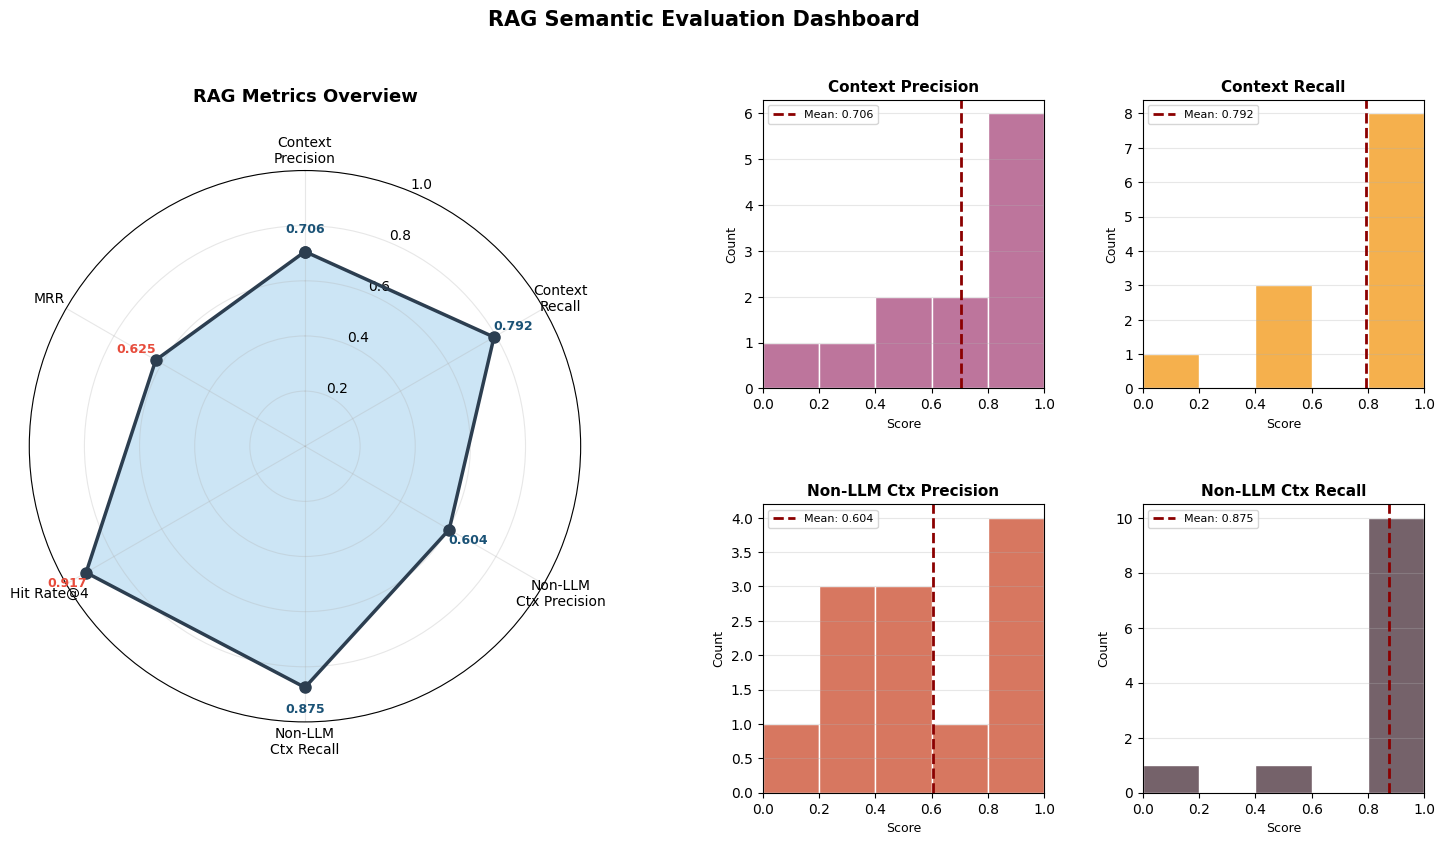

In [37]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from math import pi

%matplotlib inline

radar_metrics = ['context_precision', 'context_recall', 'non_llm_context_precision', 
                 'non_llm_context_recall', 'hit_rate@4', 'mrr']
radar_labels = ['Context\nPrecision', 'Context\nRecall', 'Non-LLM\nCtx Precision', 
                'Non-LLM\nCtx Recall', 'Hit Rate@4', 'MRR']

hist_metrics = ['context_precision', 'context_recall', 'non_llm_context_precision', 'non_llm_context_recall']
hist_labels = ['Context Precision', 'Context Recall', 'Non-LLM Ctx Precision', 'Non-LLM Ctx Recall']

radar_values = [df[m].mean() for m in radar_metrics]

fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2], wspace=0.3)

ax_radar = fig.add_subplot(gs[0, 0], projection='polar')

N = len(radar_metrics)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
values_radar = radar_values + radar_values[:1]

ax_radar.set_theta_offset(pi / 2)
ax_radar.set_theta_direction(-1)
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(radar_labels, fontsize=10)
ax_radar.set_ylim(0, 1)
ax_radar.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax_radar.grid(True, alpha=0.3)

ax_radar.plot(angles, values_radar, 'o-', linewidth=2.5, color='#2C3E50', markersize=8)
ax_radar.fill(angles, values_radar, alpha=0.25, color='#3498DB')

for i, (angle, value) in enumerate(zip(angles[:-1], values_radar[:-1])):
    color = '#E74C3C' if i >= 4 else '#1a5276'
    ax_radar.text(angle, value + 0.08, f'{value:.3f}', 
                  ha='center', va='center', 
                  fontsize=9, fontweight='bold', color=color)

ax_radar.set_title('RAG Metrics Overview', fontsize=13, fontweight='bold', pad=25)

gs_right = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], 
                                            wspace=0.35, hspace=0.4)

colors = ['#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']

for idx, (metric, label, color) in enumerate(zip(hist_metrics, hist_labels, colors)):
    row = idx // 2
    col = idx % 2
    ax = fig.add_subplot(gs_right[row, col])
    
    data = df[metric].dropna()
    sns.histplot(data, color=color, alpha=0.7, edgecolor='white', ax=ax, kde=False)
    
    mean_val = data.mean()
    ax.axvline(mean_val, color='darkred', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.3f}')
    
    ax.set_title(label, fontsize=11, fontweight='bold')
    ax.set_xlabel('Score', fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    ax.set_xlim(0, 1)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('RAG Semantic Evaluation Dashboard', fontsize=15, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()